# Heart Disease Prediction

This notebook explores a dataset with demographic information related to heart disease and different machine learning algorithms in order to create a prediction model.
This is a part of the course unit "Artificial Intelligence" of the Master in Informatics and Computing Engineering at FEUP.

#### Authors

| Name | Email |
|-----|----|
| José Luís Cunha Rodrigues | up202008462@fe.up.pt |
| Martim Raúl da Rocha Henriques | up202004421@fe.up.pt |
| Tiago Filipe Magalhães Barbosa | up202004926@fe.up.pt |

#### Imports

Firstly, we start by importing the necessay dependencies:

In [65]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.preprocessing import LabelEncoder
from pandas.core.dtypes.common import is_numeric_dtype
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn import svm


#### Analysis of the data

The dataset is composed of 18 features, most of which are related to the health condition of each individual. The target variable is the presence of heart disease in the patient, which is a binary variable. Most features are binary and some are continuos. The dataset is composed of 319795 entries.

There are no null values in the dataset. In the following cells, we will expose a summary of the dataset.

In [39]:
pd.set_option('display.max_columns', None)

df = pd.read_csv("heart_disease.csv")

df.head()

# Use a sample of the data to speed up the process
# df = df.sample(frac=0.01).reset_index(drop=True)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      3198 non-null   object 
 1   BMI               3198 non-null   float64
 2   Smoking           3198 non-null   object 
 3   AlcoholDrinking   3198 non-null   object 
 4   Stroke            3198 non-null   object 
 5   PhysicalHealth    3198 non-null   float64
 6   MentalHealth      3198 non-null   float64
 7   DiffWalking       3198 non-null   object 
 8   Sex               3198 non-null   object 
 9   AgeCategory       3198 non-null   object 
 10  Race              3198 non-null   object 
 11  Diabetic          3198 non-null   object 
 12  PhysicalActivity  3198 non-null   object 
 13  GenHealth         3198 non-null   object 
 14  SleepTime         3198 non-null   float64
 15  Asthma            3198 non-null   object 
 16  KidneyDisease     3198 non-null   object 


In [41]:
print("Null values: %d" % df.isnull().sum().sum())

Null values: 0


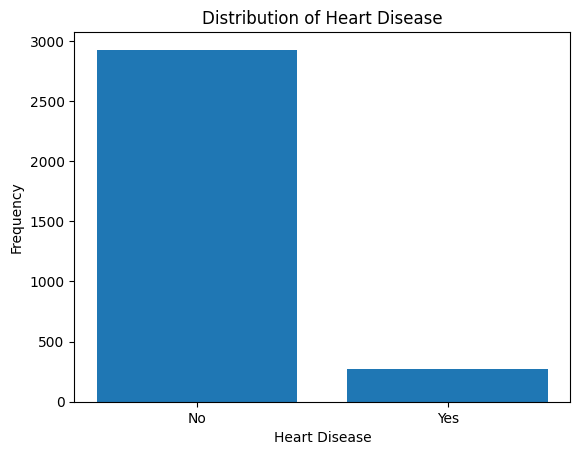

In [42]:
counts = df["HeartDisease"].value_counts()
plt.bar(counts.index, counts.values)
plt.xlabel("Heart Disease")
plt.ylabel("Frequency")
plt.title("Distribution of Heart Disease")
plt.show()

Upon first analysis, we can already see that there are no null values, which will make our job easier.

We can see that the data is imbalanced. Most of the patients analyzed were healthy. This means that we may obtain skewed results, so it is something to deal with later on.

## Preprocessing

Some of the columns have ordinal values and will require some form of formatting.
We will use Binarization to deal with these sort of columns, which include *Sex*, *Race* and *Diabetic*.

In [43]:
new_df = df.copy()

# Binarize the Sex column
sexes = new_df['Sex'].unique()
for sex in sexes:
    new_df[sex] = (new_df['Sex'] == sex)
new_df = new_df.drop("Sex", axis=1)
    
# Binarize the Race column
races = new_df['Race'].unique()
for race in races:
    new_df[race] = (new_df['Race'] == race)
new_df = new_df.drop("Race", axis=1)
    
# Binarize the Diabetic column
diabetes = new_df['Diabetic'].unique()
for diabete in diabetes:
    new_df["Diabetes: " + diabete] = (new_df['Diabetic'] == diabete)
new_df = new_df.drop("Diabetic", axis=1)
    

Because the Age Category is ordinal, we should change it in order for the data to be meaningful.
We will be taking the mean of the age so we end up with a numerical value.

In [44]:
# Define a function to transform the age category into a representative value
def transform_age(row):
    age_range = str(row).split('-')
    if (len(age_range) == 1):
      return int(age_range[0].split(' ')[0])
    age_lower = int(age_range[0])
    age_upper = int(age_range[1])
    age_representative = (age_lower + age_upper) // 2
    return age_representative

# Apply the transformation to every row in the DataFrame
new_df['AgeCategory'] = new_df['AgeCategory'].apply(transform_age)

The genHealth column is Ordinal, thus we can do label encoding to transform the categories into something ordered:

In [45]:
# Define the mapping of categories to numerical labels
label_mapping = {'Excellent': 10, 'Very good': 8, 'Good':6 , 'Fair': 3, 'Poor': 0}

# Apply label encoding to the column
new_df['GenHealth'] = new_df['GenHealth'].map(label_mapping)

Finally, all *Yes* and *No* values will be transformed to a boolean type.

In [46]:
# We need to change the column that have Yes and No to True and False respectively

new_df['HeartDisease'] = new_df['HeartDisease'].replace({'Yes': True, 'No': False})
new_df['Smoking'] = new_df['Smoking'].replace({'Yes': True, 'No': False})
new_df['AlcoholDrinking'] = new_df['AlcoholDrinking'].replace({'Yes': True, 'No': False})
new_df['Stroke'] = new_df['Stroke'].replace({'Yes': True, 'No': False})
new_df['DiffWalking'] = new_df['DiffWalking'].replace({'Yes': True, 'No': False})
new_df['PhysicalActivity'] = new_df['PhysicalActivity'].replace({'Yes': True, 'No': False})
new_df['Asthma'] = new_df['Asthma'].replace({'Yes': True, 'No': False})
new_df['KidneyDisease'] = new_df['KidneyDisease'].replace({'Yes': True, 'No': False})
new_df['SkinCancer'] = new_df['SkinCancer'].replace({'Yes': True, 'No': False})

In [47]:
new_df.head()
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3198 entries, 0 to 3197
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   HeartDisease                       3198 non-null   bool   
 1   BMI                                3198 non-null   float64
 2   Smoking                            3198 non-null   bool   
 3   AlcoholDrinking                    3198 non-null   bool   
 4   Stroke                             3198 non-null   bool   
 5   PhysicalHealth                     3198 non-null   float64
 6   MentalHealth                       3198 non-null   float64
 7   DiffWalking                        3198 non-null   bool   
 8   AgeCategory                        3198 non-null   int64  
 9   PhysicalActivity                   3198 non-null   bool   
 10  GenHealth                          3198 non-null   int64  
 11  SleepTime                          3198 non-null   float

After the processing is done, it's evident that the number of features significantly increased.
We should be weary about this, given it can lead to all sorts of problems, such as curse of dimensionality and overfitting.

Consequently, the following sections analyze the impact of the different features in order to determine which ones are relevant and which ones are not.

### Feature Selection
#### Correlation Matrix

In order to understand the correlation between the features, we will plot a correlation matrix. This will help us understand which features are more important to the prediction of heart disease.

<Axes: >

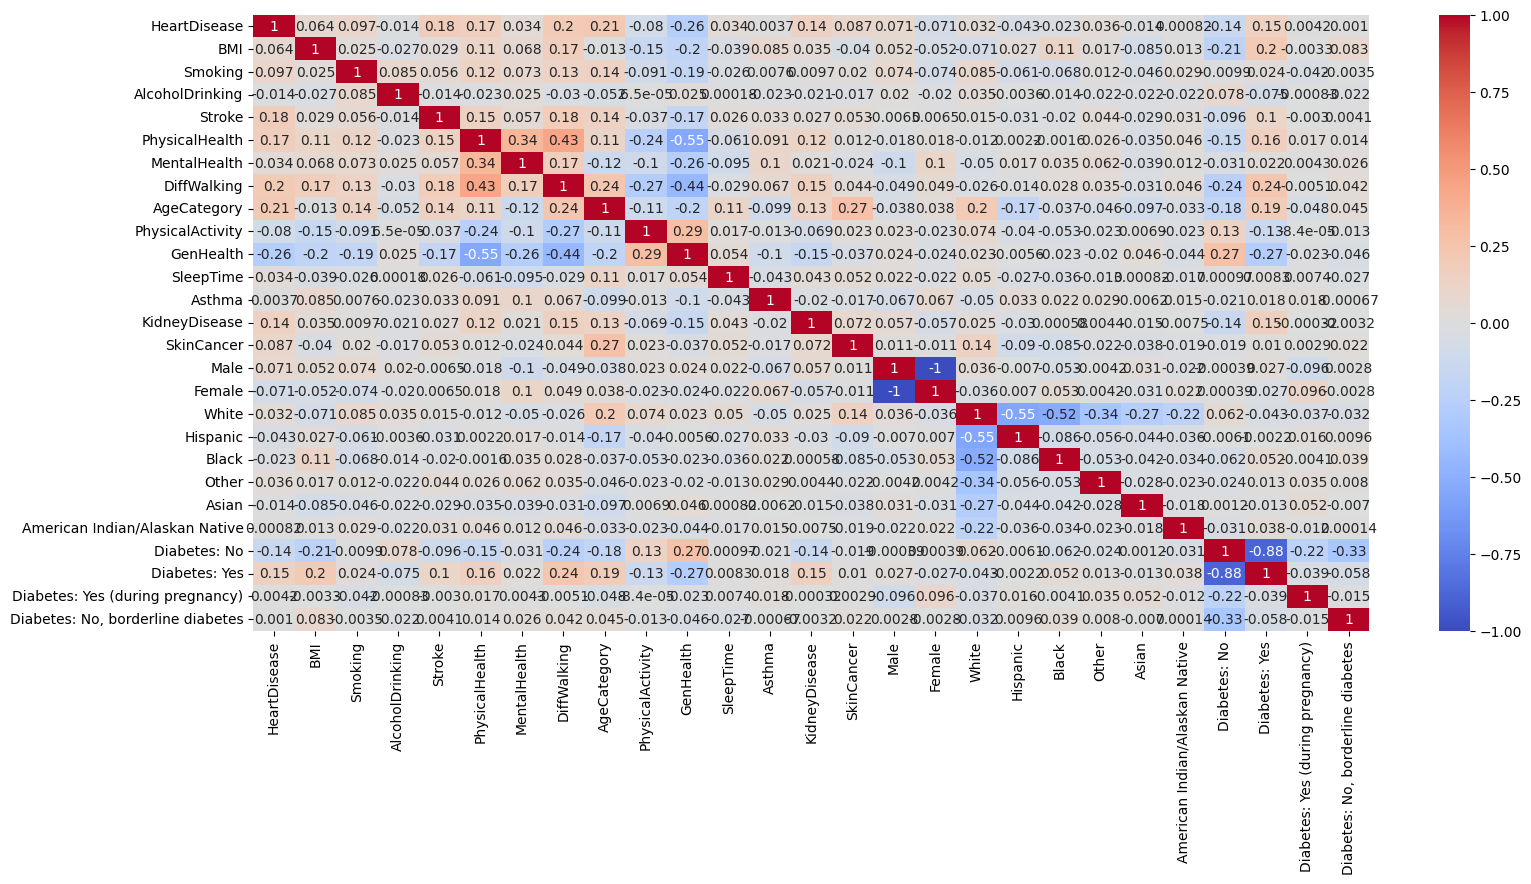

In [48]:
plt.figure(figsize=(18,8))
correlation = new_df.corr()
sb.heatmap(correlation,annot=True,cmap='coolwarm')

Taking a look at the matrix we observe that the variables more likely to affect Heart Disease are:
- Stroke
- DiffWalking
- AgeCategory
- Diabetic
- KidneyDisease

So now, we will take a closer look at how these variables affect the target variable.

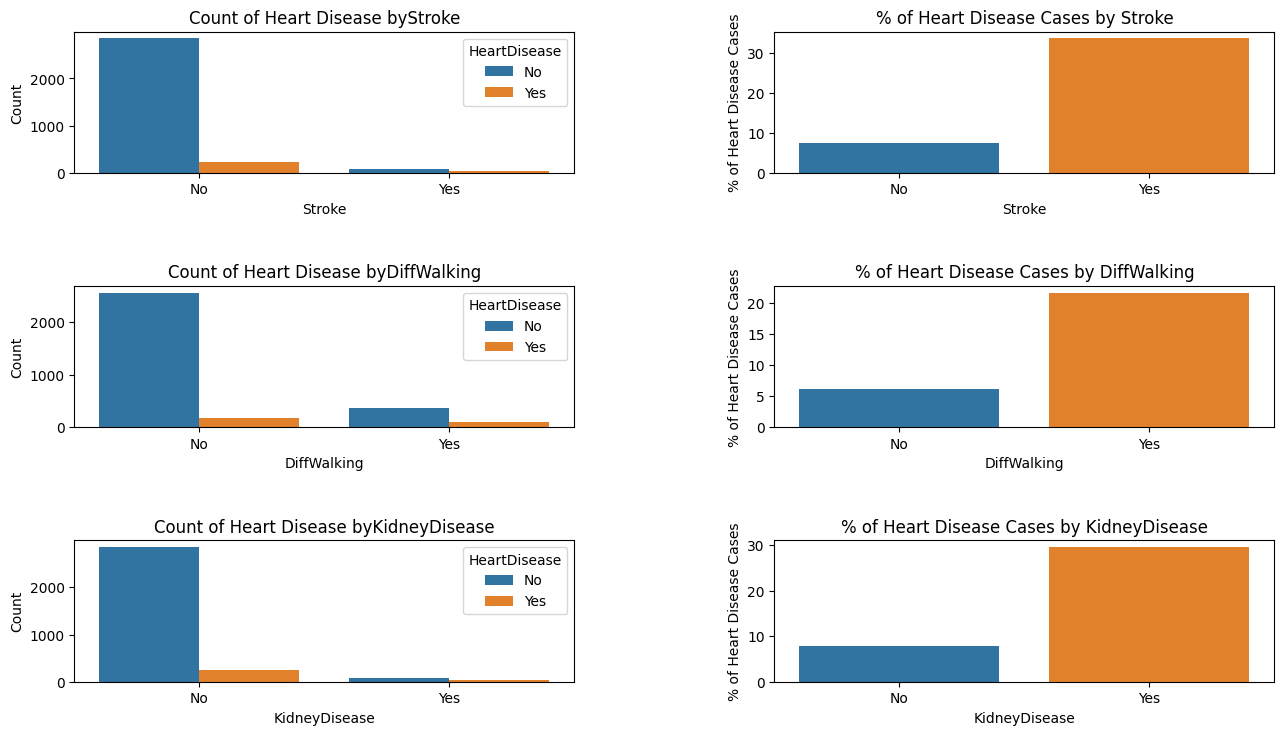

In [49]:
def plotRelation(col, ax1, ax2):
    sb.countplot(x=col, hue='HeartDisease', data=df, ax=ax1)
    ax1.set_title('Count of Heart Disease by' + col)
    ax1.set_xlabel(col)
    ax1.set_ylabel('Count')

    perc_stroke = df.groupby(col)['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

    sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
    ax2.set_title('% of Heart Disease Cases by ' + col)
    ax2.set_xlabel(col)
    ax2.set_ylabel('% of Heart Disease Cases')


fig, axes = plt.subplots(3, 2, figsize=(15, 5))

plotRelation('Stroke', axes[0, 0], axes[0, 1])
plotRelation('DiffWalking', axes[1, 0], axes[1, 1])
plotRelation('KidneyDisease', axes[2, 0], axes[2, 1])

plt.subplots_adjust(top=1.4, bottom=0.1, left=0.1, right=0.9, hspace=0.8, wspace=0.4)

According to the graph above, there is a higher chance of having heart disease if the patient has had a stroke.
We can see that the percentage of people with heart disease that had a stroke was around five times higher than the percentage of people with heart disease that did not have a stroke.

Again, we can state that the more a patient has difficulty walking, the more likely it is that he has heart disease. 
The percentage of people with heart disease that have difficulty walking is around 5 times higher than the percentage of people with heart disease that do not have difficulty walking.

Moreover, patients with kidney disease have a higher tendency to suffer from heart disease.
In this case, almost 30% of the patients with kidney disease also have heart disease. 
On the other hand, only around 7% of the patients without kidney disease have heart disease.

#### Age Category

Text(0, 0.5, 'Percentage')

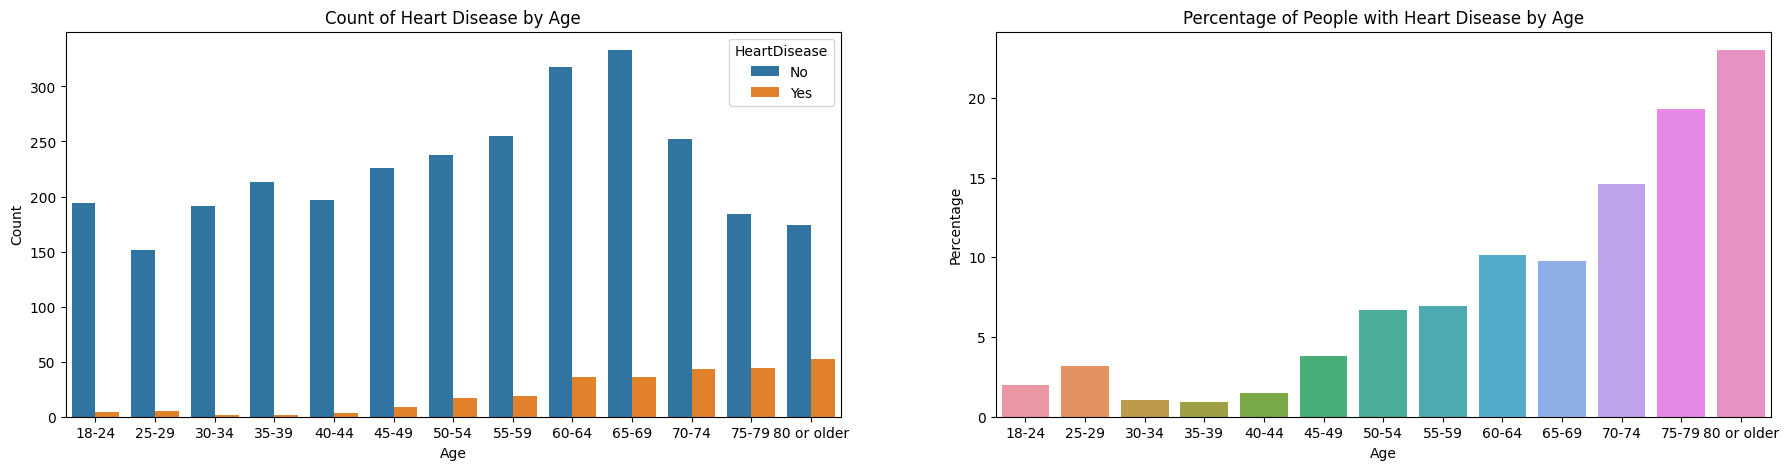

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(22, 5))

age_order = ['18-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80 or older']

df['AgeCategory'] = pd.Categorical(df['AgeCategory'], categories=age_order, ordered=True)

sb.countplot(x='AgeCategory', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Age')
ax1.set_xlabel('Age')
ax1.set_ylabel('Count')

age_df = df.groupby('AgeCategory')['HeartDisease'].value_counts(normalize=True).mul(100).rename('Percentage').reset_index()
age_df = age_df[age_df['HeartDisease']=='Yes']
sb.barplot(x='AgeCategory', y='Percentage', data=age_df, ax=ax2)
ax2.set_title('Percentage of People with Heart Disease by Age')
ax2.set_xlabel('Age')
ax2.set_ylabel('Percentage')


As we can see on the above graph, the percentage of patients with heart disease consistently increases with age. 
It's also noticeable that the data is fairly distributed across all ages.

#### Diabetic

Text(0, 0.5, 'Percentage of Heart Disease Cases')

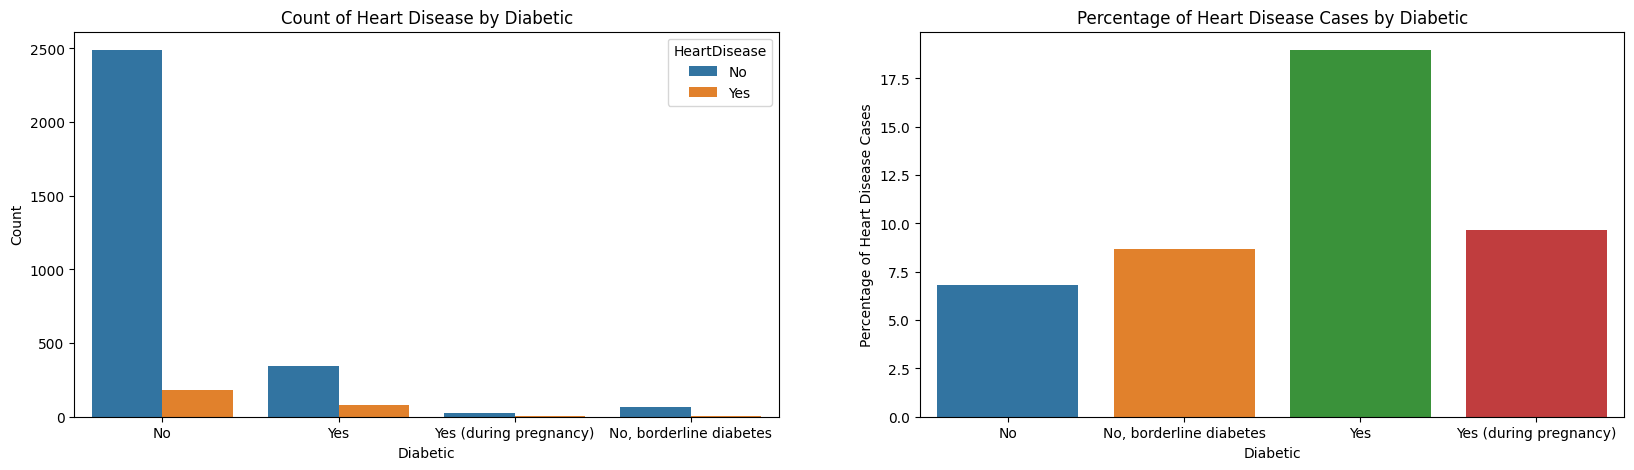

In [51]:
# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

sb.countplot(x='Diabetic', hue='HeartDisease', data=df, ax=ax1)
ax1.set_title('Count of Heart Disease by Diabetic')
ax1.set_xlabel('Diabetic')
ax1.set_ylabel('Count')

# create a grouped dataframe to calculate percentage
perc_stroke = df.groupby('Diabetic')['HeartDisease'].value_counts(normalize=True)[:, 'Yes'] * 100

# Create bar plot
sb.barplot(x=perc_stroke.index, y=perc_stroke.values, ax=ax2)
ax2.set_title('Percentage of Heart Disease Cases by Diabetic')
ax2.set_xlabel('Diabetic')
ax2.set_ylabel('Percentage of Heart Disease Cases')

In [52]:
# get the average age of diabetic during pregnancy
gest_df = new_df.loc[new_df['Diabetes: Yes (during pregnancy)']==True]
print("Average age of patients with gestational diabetes: %d" % gest_df['AgeCategory'].mean())

Average age of patients with gestational diabetes: 46


Base on the data, people with diabetes have a higher tendency to suffer from heart disease.


According to the graph, for patients with gestational diabetes (i.e. during pregnancy) leads to a lower percentage of heart disease.
Nevertheless, this can be due to a set of reasons:
- The data is not representative enough
- This condition is only present during a limited period of a person's life
- The patients measured are expected to be younger than the average age of people with heart disease

With the above analysis in mind, we will now complete our conclusions with empirical evidence for the importance of each feature.

To do that, the following strategies will be used:
- **Correlation**: Remove features that do not satisfy a certain correlation threshold
- **Mutual information scores**: Measure the statistical dependence and information shared between variables
- **Recursive Feature Elimination (RFE)**: Technique that recursively selects features by eliminating the least important ones based on a model's coefficients or feature importance.

In [53]:
# Correlation

X = new_df.drop('HeartDisease', axis=1)
y = new_df['HeartDisease']
df_selection = pd.DataFrame(columns=['strategy'] + list(X.columns))

cols = []
for col in X.columns:
    cols.append(abs(new_df[col].corr(new_df['HeartDisease'])) >= 0.1)

df_selection.loc[0, :] = ['Correlation'] + cols

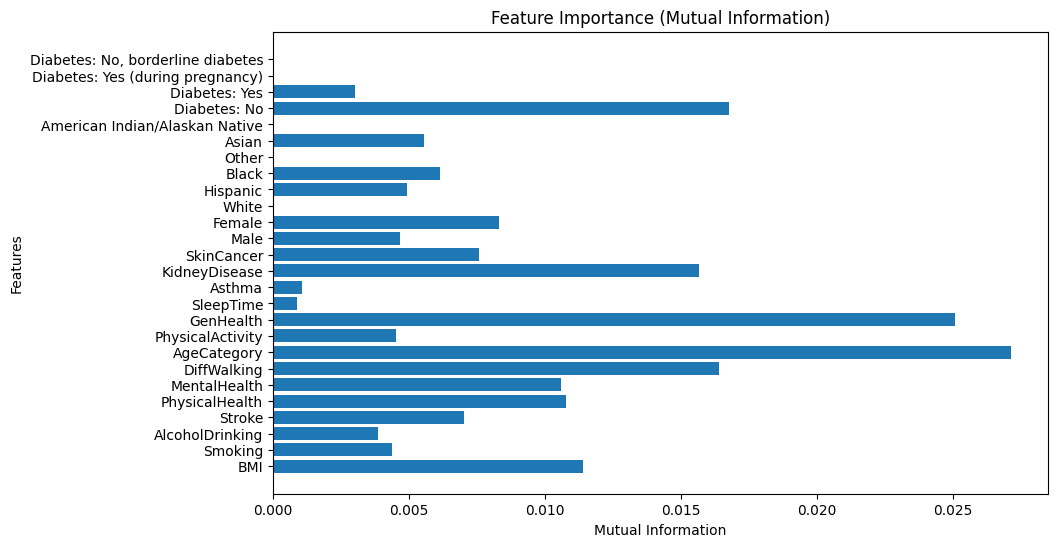

In [54]:
# Mutual Information

from sklearn.feature_selection import mutual_info_classif

X = new_df.drop('HeartDisease', axis=1)
y = new_df['HeartDisease']

# Compute mutual information scores
mi_scores = mutual_info_classif(X, y)

# Plot feature importance (Mutual Information)
plt.figure(figsize=(10, 6))
plt.barh(X.columns, mi_scores)
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Feature Importance (Mutual Information)')
plt.show()

cols = []
# get the cols from mi_scores with score >= 0.1
for col in X.columns:
    cols.append(mi_scores[X.columns.get_loc(col)] >= 0.03)

df_selection.loc[1, :] = ['Mutual Information'] + cols

In [55]:
# Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.feature_selection import mutual_info_classif

X = new_df.drop('HeartDisease', axis=1)
y = new_df['HeartDisease']

model = DecisionTreeClassifier()

# Create an instance of RFE with the model and the desired number of features to select
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit RFE to your data
rfe.fit(X, y)

# Get the selected features
selected_features = rfe.transform(X)

# Get the names of the selected features
selected_feature_names = X.columns[rfe.support_]

cols = []
# get the cols from mi_scores with score >= 0.1
for col in X.columns:
    cols.append(col in selected_feature_names)

df_selection.loc[2, :] = ['RFE'] + cols

In [56]:
selection = df_selection.loc[:, (df_selection == True).sum() >= 2].columns
selection = selection[:-1] #remove sum from selection
selection = pd.Index(["HeartDisease"]).append(selection)

print(selection.values)
new_df = new_df[selection]
new_df.head()

['HeartDisease' 'PhysicalHealth' 'AgeCategory' 'GenHealth']


,HeartDisease,PhysicalHealth,AgeCategory,GenHealth
0,False,0.0,32,8
1,False,0.0,62,8
2,False,0.0,62,10
3,False,0.0,42,8
4,False,2.0,62,6


## Classification

Now, we can start the classification process. We will start by splitting the dataset into training and testing sets. The size of the testing set will be 20% of the total dataset.

Firstly, let's define general use functions:

In [57]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample

def balance():
    X = new_df.drop('HeartDisease', axis=1)
    y = new_df['HeartDisease']

    # Identify the indices of majority and minority class instances
    majority_indices = y[y == False].index
    minority_indices = y[y == True].index

    desired_majority_size = len(minority_indices)  # Set to the same size as the minority class

    # Determine the number of instances to keep from the majority class
    desired_majority_size = len(minority_indices)  # Set to the same size as the minority class

    # Randomly select instances from the majority class
    undersampled_majority_indices = resample(
        majority_indices,
        replace=False,  # Without replacement
        n_samples=desired_majority_size,  # Number of instances to keep
        random_state=42
    )

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)

    # Combine the undersampled majority class instances with the minority class instances
    undersampled_indices = np.concatenate((undersampled_majority_indices, minority_indices))
    X_balanced = X.loc[undersampled_indices]
    y_balanced = y.loc[undersampled_indices]
    return (X_balanced, y_balanced)
    

def runModel(model, analysis=True):
    results = pd.DataFrame(columns=['strategy', 'accuracy', 'precision', 'recall', 'f1'])
    X = new_df.drop('HeartDisease', axis=1)
    y = new_df['HeartDisease']

    # Convert categorical variables into numerical using one-hot encoding
    X = pd.get_dummies(X)

    if analysis:
        # Run the model without balancing
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        model.fit(X_train, y_train)
        _y_pred, accuracy, precision, recall, f1 = getMetrics(model, X_test, y_test)
        results.loc[0, :] = ['unbalanced', accuracy, precision, recall, f1]

        # Run the model with oversampling
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
        model.fit(X_train, y_train)
        _y_pred, accuracy, precision, recall, f1 = getMetrics(model, X_test, y_test)
        results.loc[1, :] = ['oversampling', accuracy, precision, recall, f1]

    # Run the model with undersampling
    X, y = balance()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model.fit(X_train, y_train)
    _y_pred, accuracy, precision, recall, f1 = getMetrics(model, X_test, y_test)
    results.loc[2, :] = ['undersampling', accuracy, precision, recall, f1]

    if analysis: 
        display(results)
        analyze(model, X_test, y_test)

    return accuracy

def runModelRepeatedly(model):
    model_accuracies = []
    X, y = balance()

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Convert categorical variables into numerical using one-hot encoding
        X = pd.get_dummies(X)

        model.fit(X_train, y_train)

        # Predict the target variable for the testing data
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        
        model_accuracies.append(accuracy)

    plt.hist(model_accuracies)

def getMetrics(model, testing_inputs, testing_classes):
    model.score(testing_inputs, testing_classes)

    y_pred = model.predict(testing_inputs)

    accuracy = accuracy_score(testing_classes, y_pred)
    precision = precision_score(testing_classes, y_pred)
    recall = recall_score(testing_classes, y_pred)
    f1 = f1_score(testing_classes, y_pred)
    return (y_pred, accuracy, precision, recall, f1)

def analyze(model, testing_inputs, testing_classes):
    y_pred, accuracy, precision, recall, f1 = getMetrics(model, testing_inputs, testing_classes)


    cm = confusion_matrix(testing_classes, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(5, 5))
    sb.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion matrix (undersampling)')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


#### Decision Tree

,strategy,accuracy,precision,recall,f1
0,unbalanced,0.901563,0.136364,0.06383,0.086957
1,oversampling,0.779687,0.15942,0.468085,0.237838
2,undersampling,0.688073,0.72093,0.584906,0.645833


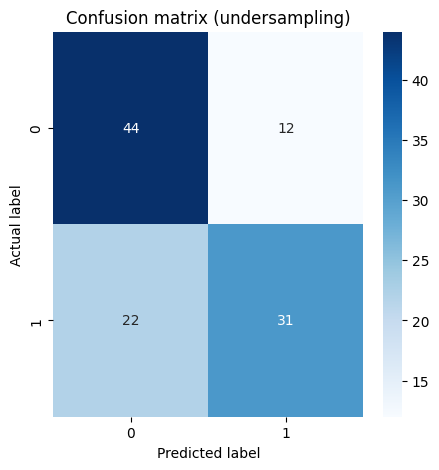

In [58]:
accuracy = runModel(DecisionTreeClassifier(random_state=42))

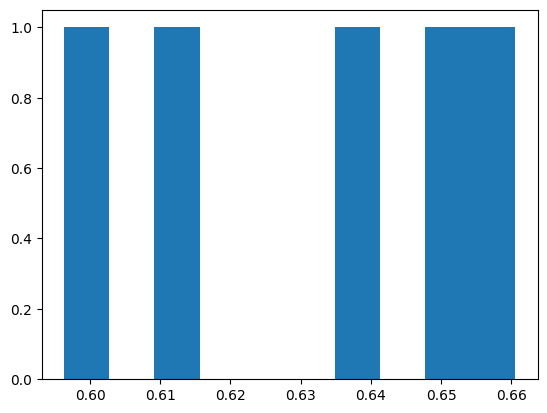

In [59]:
runModelRepeatedly(DecisionTreeClassifier())

#### Support Vector Machines (SVM)

In [60]:
clf = svm.SVC(kernel='linear')

# commenting out because it takes a long time to run
runModel(clf, False)

0.7155963302752294

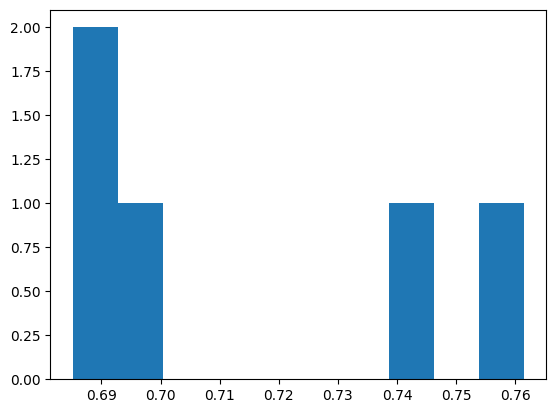

In [61]:
# commenting out because it takes a long time to run
runModelRepeatedly(clf)

In [66]:
X, y = balance()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 10]
}

svm = svm.SVC()

grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

accuracy = best_model.score(X_test, y_test)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameters: {'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'}
Best score: 0.7172413793103448


#### K-Neighbours Classifier

,strategy,accuracy,precision,recall,f1
0,unbalanced,0.901563,0.3,0.050847,0.086957
1,oversampling,0.870313,0.23913,0.186441,0.209524
2,undersampling,0.660714,0.557143,0.847826,0.672414


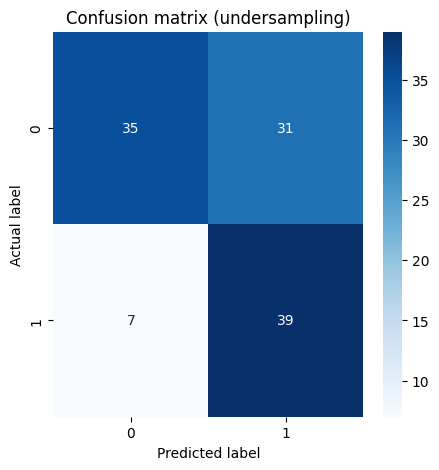

In [29]:
clf = KNeighborsClassifier(n_neighbors=5)
accuracy = runModel(clf)

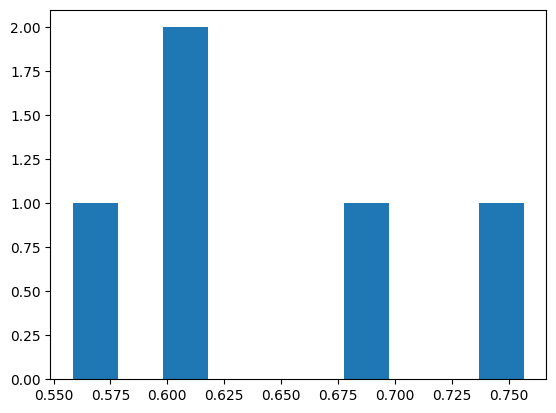

In [30]:
runModelRepeatedly(clf)

Text(0, 0.5, 'Testing Accuracy')

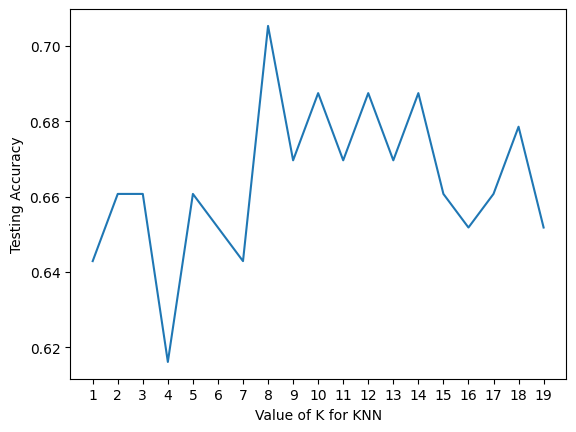

In [31]:
scores = []
n = 20

for k in range (1, n):
    clf = KNeighborsClassifier(n_neighbors=k)
    scores.append(runModel(clf, False))

# plot the relationship between K and testing accuracy
plt.plot(range(1, n), scores)
plt.xticks(np.arange(1, n, 1))
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')


In [32]:
# get max and its index
max_accuracy = np.max(scores)
max_accuracy_index = scores.index(max_accuracy)
print("Max accuracy: " + str(max_accuracy), "at k = " + str(max_accuracy_index + 1))

Max accuracy: 0.7053571428571429 at k = 8


We tested k-NN algorithm with different values of k. The best results were obtained with larger values of k, which is expected since the data is imbalanced. The best value obtained as around 0.74 with 19 neighbours. After that, the accuracy starts to stabilize with no significant improvement.

#### Random Forest

,strategy,accuracy,precision,recall,f1
0,unbalanced,0.90625,0.466667,0.118644,0.189189
1,oversampling,0.789062,0.224638,0.525424,0.314721
2,undersampling,0.6875,0.57971,0.869565,0.695652


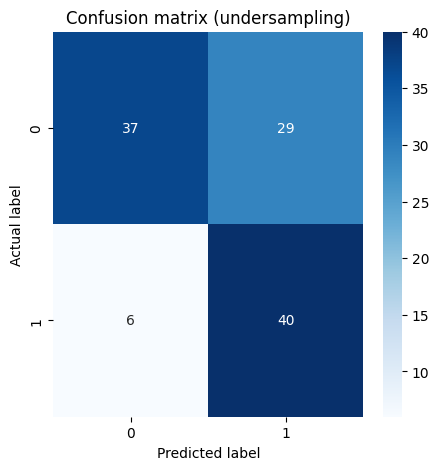

Accuracy: 0.6875


In [33]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
accuracy = runModel(clf)
print("Accuracy: " + str(accuracy))

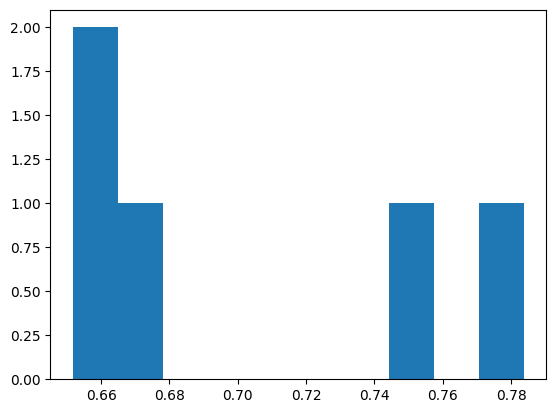

In [34]:
clf = RandomForestClassifier(n_estimators=100)
runModelRepeatedly(clf)

#### Naive Bayes

,strategy,accuracy,precision,recall,f1
0,unbalanced,0.86875,0.341772,0.457627,0.391304
1,oversampling,0.823438,0.275,0.559322,0.368715
2,undersampling,0.651786,0.577778,0.565217,0.571429


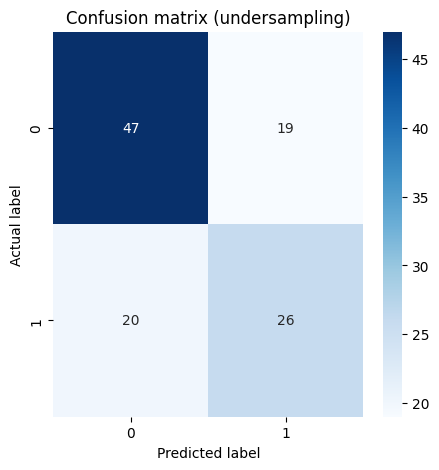

0.6517857142857143

In [35]:
# naive bayes
clf = GaussianNB()
runModel(clf)

#### Neural networks

,strategy,accuracy,precision,recall,f1
0,unbalanced,0.90625,0.0,0.0,0.0
1,oversampling,0.778125,0.242236,0.661017,0.354545
2,undersampling,0.696429,0.596774,0.804348,0.685185


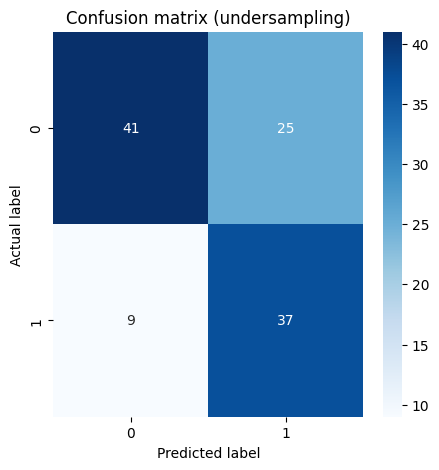

0.6964285714285714

In [36]:
clf = MLPClassifier(hidden_layer_sizes=(10, 5), activation='relu', solver='adam', max_iter=1000, random_state=42)
runModel(clf)

In [37]:
X, y = balance()
X = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf = MLPClassifier()

param_grid = {
    'hidden_layer_sizes': [(10,), (20,), (10, 5)],
    'activation': ['relu', 'logistic'],
    'solver': ['adam', 'sgd'],
    'max_iter': [500, 1000]
}

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

/home/luis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luis/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/luis/.local/lib/python3.10/site-packages/sklearn/n

Best parameters: {'activation': 'relu', 'hidden_layer_sizes': (10, 5), 'max_iter': 500, 'solver': 'adam'}
Best score: 0.7456588355464759
